In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from ngio import open_ome_zarr_plate, open_ome_zarr_container

In [2]:
plate_fld = Path("/Volumes/active/rhornb/fractal_paper/data_all/AssayPlate_Greiner_CELLSTAR655090.zarr")
ome_zarr_plate = open_ome_zarr_plate(plate_fld)

In [3]:
# Load images
well_acq_paths = ome_zarr_plate.images_paths(acquisition=1)[:6]
n_wells = len(well_acq_paths)

level = "3"
channel_name = "DAPI_1"

well_imgs_dict = {}
for i, well_path in enumerate(well_acq_paths):
    file_path = plate_fld / well_path
    ome_zarr_container = open_ome_zarr_container(file_path)
    roi_table = ome_zarr_container.get_roi_table("FOV_ROI_table")
    images = ome_zarr_container.get_image(level)
    channel_id = images.channels_meta.get_channel_idx(channel_name)
    imgs = []
    for roi in roi_table.rois():
        img_lazy = images.get_roi(c=channel_id, roi=roi, mode="dask").squeeze()
        imgs.append(img_lazy)
    well_imgs_dict[well_path] = imgs

In [4]:
n_embryos_max = max(len(imgs) for imgs in well_imgs_dict.values())
max_extent = np.array(
    [img.shape for imgs in well_imgs_dict.values() for img in imgs]).max(axis=0)
dz, dy, dx = max_extent
expected_shape = (dz, dy, dx)

canvas = np.zeros((dz, n_embryos_max * dy, n_wells * dx), dtype=np.uint16)

# Function to paste an image onto the canvas
def paste_image(canvas, img, y, x, dy, dx):
    cy, cx = y * dy, x * dx
    if cx + dx > canvas.shape[2] or cy + dy > canvas.shape[1]:
        raise ValueError(f"Image at ({y}, {x}) with shape {img.shape} exceeds canvas bounds.")
    canvas[:, cy:cy + dy, cx:cx + dx] = img

# Initialize variables to track the current well and position
current_well = well_acq_paths[0]
y, x = 0, 0
# Loop through images and arrange them on the canvas
for well, imgs in well_imgs_dict.items():
    if well != current_well:
        x += 1
        y = 0
        current_well = well
    print(f"Placing {well=} at ({y}, {x})")
    try:
        for img in imgs:
            img_np = img.compute()
            # Pad to expected shape if necessary
            if img_np.shape != expected_shape:
                img_np = np.pad(img_np, ((0, dz - img_np.shape[0]), (0, dy - img_np.shape[1]), (0, dx - img_np.shape[2])), mode='constant')
            paste_image(canvas, img_np, y, x, dy, dx)
            y += 1
    except ValueError as e:
        print(f"Error placing image: {e}")
        break  # Exit the loop if an error occurs

Placing well='B/02/1' at (0, 0)
Placing well='B/05/1' at (0, 1)
Placing well='B/06/1' at (0, 2)
Placing well='B/07/1' at (0, 3)
Placing well='C/02/1' at (0, 4)
Placing well='C/04/1' at (0, 5)


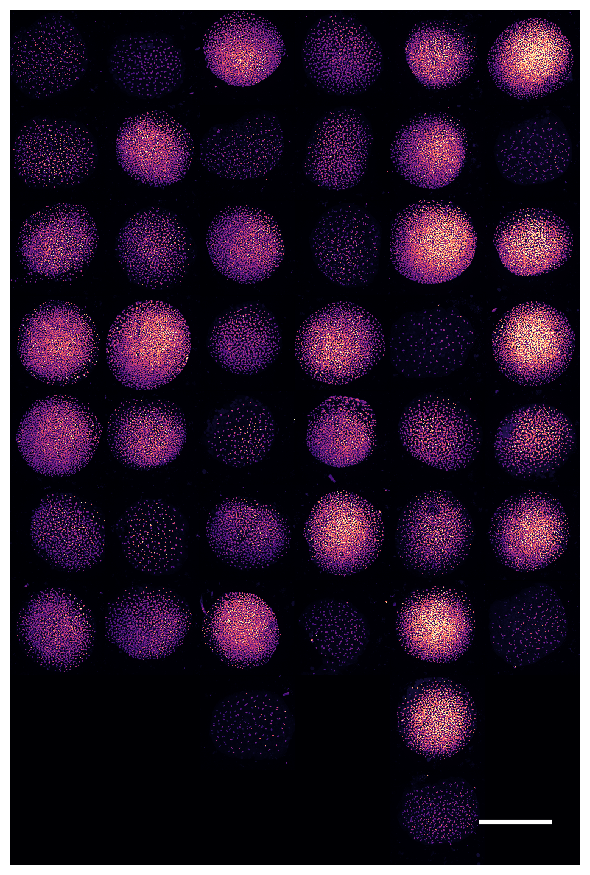

In [5]:
# Make xy maximum projection of canvas and plot 
canvas_max_proj = np.max(canvas, axis=0)
canvas_max_proj = np.rot90(canvas_max_proj, 2)
um_per_px_y, um_per_px_x = images.pixel_size.yx
ny, nx = canvas_max_proj.shape 

# Extent in microns
extent = [0, nx * um_per_px_x, 0, ny * um_per_px_y]

# Figure size that preserves physical aspect ratio (choose any base width)
base_width_in = 6
width_um = extent[1] - extent[0]
height_um = extent[3] - extent[2]
fig_height_in = base_width_in * (height_um / width_um)

fig, ax = plt.subplots(1, 1, figsize=(base_width_in, fig_height_in))
im = ax.imshow(
    canvas_max_proj,
    origin="lower",
    cmap="magma",
    extent=extent,
    interpolation="nearest",
    vmin=0,
    vmax=1000,
)
# ax.set_xlabel("z (µm)")
# ax.set_ylabel("y (µm)")
ax.set_aspect("equal")
ax.axis("off")

# Optional simple scalebar: 10% of width
scalebar_um = 500
margin_um = 0.05 * width_um
x0 = extent[1] - margin_um - scalebar_um  # right margin
y0 = extent[2] + 0.05 * height_um         # bottom margin; for top-right use: extent[3] - 0.05 * height_um
ax.hlines(y=y0, xmin=x0, xmax=x0 + scalebar_um, colors="white", linewidth=3)
# plt.savefig("zfish_grid.png", dpi=600, bbox_inches="tight", pad_inches=0.1, transparent=True)
plt.tight_layout()

In [6]:
# Make xz maximum projection of canvas and plot 
canvas_max_proj = np.max(canvas, axis=1)
um_per_px_y, um_per_px_x = images.pixel_size.yx
um_per_px_z = images.pixel_size.z
ny, nx = canvas_max_proj.shape 

# Extent in microns
extent = [0, nx * um_per_px_x, 0, ny * um_per_px_z]

# Figure size that preserves physical aspect ratio (choose any base width)
base_width_in = 6
width_um = extent[1] - extent[0]
height_um = extent[3] - extent[2]
fig_height_in = base_width_in * (height_um / width_um)

fig, ax = plt.subplots(1, 1, figsize=(base_width_in, fig_height_in))
im = ax.imshow(
    canvas_max_proj,
    origin="lower",
    cmap="magma",
    extent=extent,
    interpolation="nearest",
    vmin=0,
    vmax=2000,
)
ax.set_aspect("equal")
ax.axis("off")

# plt.savefig("zfish_grid_xz.png", dpi=300, bbox_inches="tight", pad_inches=0.1, transparent=True)
plt.tight_layout()

/var/folders/2d/ls0vzxys1fl9ggjj4gnk_nww9pg43g/T/ipykernel_34584/3298121581.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


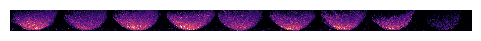

In [7]:
# Make yz maximum projection of canvas and plot 
canvas_max_proj = np.max(canvas, axis=2)
um_per_px_y, um_per_px_x = images.pixel_size.yx
um_per_px_z = images.pixel_size.z
ny, nx = canvas_max_proj.shape 

# Extent in microns
extent = [0, nx * um_per_px_x, 0, ny * um_per_px_z]

# Figure size that preserves physical aspect ratio (choose any base width)
base_width_in = 6
width_um = extent[1] - extent[0]
height_um = extent[3] - extent[2]
fig_height_in = base_width_in * (height_um / width_um)

fig, ax = plt.subplots(1, 1, figsize=(base_width_in, fig_height_in))
im = ax.imshow(
    canvas_max_proj,
    origin="lower",
    cmap="magma",
    extent=extent,
    interpolation="nearest",
    vmin=0,
    vmax=2000,
)
ax.set_aspect("equal")
ax.axis("off")

# plt.savefig("zfish_grid_yz.png", dpi=300, bbox_inches="tight", pad_inches=0.1, transparent=True)
plt.tight_layout()